In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%pwd

'/content'

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# This is in my google drive
train_dataset_directory = '/content/drive/MyDrive/Dataset/train/train'
test_dataset_directory = '/content/drive/MyDrive/Dataset/test/test'

training_dataset = image_dataset_from_directory(train_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224),
                                             seed = 42,
                                             subset= 'training',
                                             validation_split=0.2) # 20% of data will be used for validation)                        https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

validation_datset = image_dataset_from_directory(train_dataset_directory,
                                              validation_split=0.2, # 20% of data will be used for validation
                                              subset='validation',
                                              seed=42, # random number shuffler of data. Same as training for consistency
                                              image_size=(224, 224),
                                              batch_size=32)

test_dataset = image_dataset_from_directory(test_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224)) 



class_names = training_dataset.class_names
print(class_names)


Found 993 files belonging to 3 classes.
Using 795 files for training.
Found 993 files belonging to 3 classes.
Using 198 files for validation.
Found 267 files belonging to 3 classes.
['paper', 'plastic', 'trash']


In [3]:
from tensorflow.data.experimental import AUTOTUNE

# Allows the system to automatiucally determine optimal buffer size. May help improve traininng speed
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE) 

In [4]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential
# data augeentation here. https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

# Data augmentation layers. This does NOT increase the amount of data. Instead it augements on the Fly
# Meaning during training the model will randomly see the data rotated, flipped, zoomed or translated
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomFlip("horizontal"),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])


train_ds = training_dataset.map(lambda images, labels: (data_augmentation(images), labels))
print(train_ds)


<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
# pre process input 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# pre-processes by the mean and standard deviation of certain values, while making the pixels be between [-1,1] See here https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
train_ds = training_dataset.map(lambda images, labels: (preprocess_input(images), labels))
val_ds = validation_datset.map(lambda images, labels: (preprocess_input(images), labels))
test_dataset = test_dataset.map(lambda images, labels: (preprocess_input(images), labels))

In [6]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model

# Import pretrained model on ImageNet. Keep input shape same as ImageNet. Dont include classification layer
model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.trainable = None # freeze the weights
model.summary()

# Retrieve the last layer
last_layer_output = model.output

# Add the Pooling layer on top (why? The default mobileNetV2 has one. We are using it as a custom fit)
pooling_features = GlobalAveragePooling2D()(last_layer_output)

# Adds a fully connected layer
dense_layer_output = Dense(1024, activation='relu')(pooling_features)

# Another Fully Connected layer on top. value of 3 because we have 3 classes [paper, plastic, trash]
prediction_output = Dense(3, activation='softmax')(dense_layer_output)

model = Model(inputs=model.input, outputs=prediction_output)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [7]:
# Standard params. Adam and sparse loss are community defaults
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_ds,
    epochs=19,
    validation_data=val_ds,
    verbose = 2)

"""
Validation loss improved slighlty and oscillated. The learning rate might be too high. Another option is to test with a smaller learning rate

Consider using BGD as the batch size. Ideal for data less than 2000. To use BGD

history = model.fit(
    train_ds,
    epochs=19,
    validation_data=val_ds,
    verbose = 2,
    batch_size = train_ds)
"""

Epoch 1/19
25/25 - 132s - loss: 0.8077 - accuracy: 0.7509 - val_loss: 0.3988 - val_accuracy: 0.8384 - 132s/epoch - 5s/step
Epoch 2/19
25/25 - 53s - loss: 0.2234 - accuracy: 0.9270 - val_loss: 0.3018 - val_accuracy: 0.8939 - 53s/epoch - 2s/step
Epoch 3/19
25/25 - 51s - loss: 0.1052 - accuracy: 0.9711 - val_loss: 0.2786 - val_accuracy: 0.8990 - 51s/epoch - 2s/step
Epoch 4/19
25/25 - 61s - loss: 0.0447 - accuracy: 0.9899 - val_loss: 0.2866 - val_accuracy: 0.9091 - 61s/epoch - 2s/step
Epoch 5/19
25/25 - 59s - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.3075 - val_accuracy: 0.8889 - 59s/epoch - 2s/step
Epoch 6/19
25/25 - 48s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9040 - 48s/epoch - 2s/step
Epoch 7/19
25/25 - 47s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.9040 - 47s/epoch - 2s/step
Epoch 8/19
25/25 - 49s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.3246 - val_accuracy: 0.9040 - 49s/epoch - 2s/step
Epoch 9/19
25/25 - 50s - loss:

In [9]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


9/9 [==============================] - 41s 1s/step - loss: 0.3319 - accuracy: 0.9176
Test accuracy: 91.76%


In [10]:
model.save('mobileNetV2.h5')


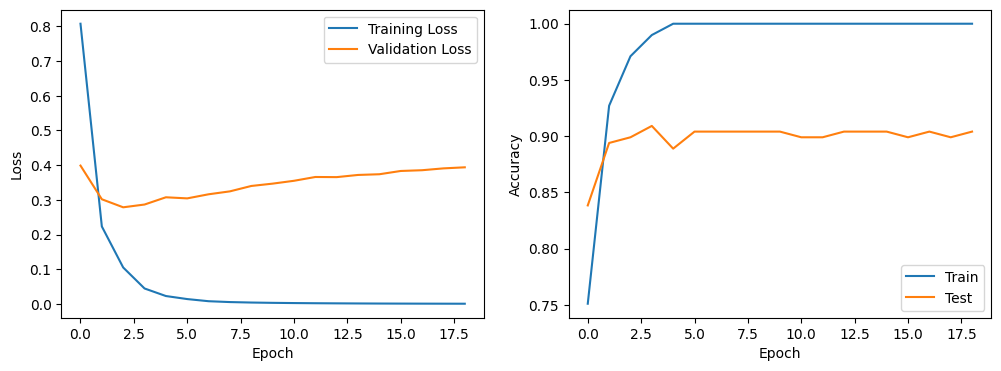

'\nGraph one shows that the model is learning, mbut failed to generalize on the validation.\nThis is a form of overfitting the data. Our model is too complex for our data.\n\nSolutions: Obtain more data to avoid overfitting or perform overfitting techniques\n'

In [14]:
import matplotlib.pyplot as plt

# Plot the training/validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

"""
Graph one shows that the model is learning, mbut failed to generalize on the validation.
This is a form of overfitting the data. Our model is too complex for our data.

Solutions: Obtain more data to avoid overfitting or perform overfitting techniques
"""

In [13]:
model.save('/content/drive/MyDrive//mobileNetV2.h5')
# previous save saved somewhere i dont know